In [ ]:
from quri_parts.core.operator import Operator, pauli_label
from scipy.optimize import minimize
import numpy as np
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit, Parameter
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
import networkx as nx

In [ ]:
# Build an example graph
graph = {
    'nodes': list(range(5)),
    'edges': [
        (0, 1), (0, 2), (1, 2),
        (0, 3), (2, 4)
    ]
}

G = nx.Graph()
G.add_nodes_from(graph['nodes'])
G.add_edges_from(graph['edges'])

nodes = G.nodes()
num_qubits = len(nodes)

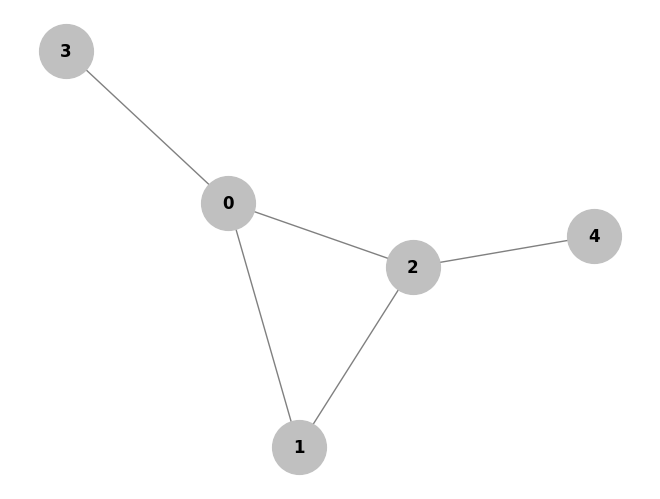

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

full_graph_color = "#C0C0C0"
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold")

plt.show()

In [ ]:
# Define Hamiltonian of Max Clique problem
obs_dict = {}

def add_term(term: str, coeff: float):
    key = pauli_label(term)
    if key in obs_dict:
        obs_dict[key] += coeff
    else:
        obs_dict[key] = coeff

# 1. For each vertex i, act -(1-Z_i)/2 = -0.5*I + 0.5*Z_i
for i in range(num_qubits):
    add_term({}, -0.5)
    add_term(f"Z{i}", 0.5)   # -0.5 * Z_i

# 2. For each vertex pair (i,j) (i<j) add panelty if they aren't adjacented：
#    A/4*(1 - Z_i - Z_j + Z_i Z_j)
A = 2
for i in range(num_qubits):
    for j in range(i+1, num_qubits):
        if (i, j) not in G.edges and (j, i) not in G.edges:
            add_term({}, A/4)           # constant: A/4 * I
            add_term(f"Z{i}", -A/4)         # -A/4 * Z_i
            add_term(f"Z{j}", -A/4)         # -A/4 * Z_j
            add_term(f"Z{i} Z{j}", A/4)    # A/4 * Z_i Z_j

cost_observable = Operator(obs_dict)

In [ ]:
# A function to add U_C(gamma) to a circuit
def add_U_C(circuit: LinearMappedUnboundParametricQuantumCircuit, gamma_idx: int) -> None:
    gamma = circuit.add_parameter(f"gamma_{gamma_idx}")
    # Single qubit term: exp(i*theta/2*Z)
    for i in range(num_qubits):
        circuit.add_ParametricRZ_gate(i, {gamma: -2})

    # Two qubits term( penalty): exp(i*A/4*theta*(-Zi-Zj+Zi*Zj))
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            if (i, j) not in G.edges and (j, i) not in G.edges:
                circuit.add_ParametricRZ_gate(i, {gamma: 4})
                circuit.add_ParametricRZ_gate(j, {gamma: 4})
                circuit.add_CNOT_gate(i, j)
                circuit.add_ParametricRZ_gate(j, {gamma: -4})
                circuit.add_CNOT_gate(i, j)


# A function to add U_X(beta) to a circuit
def add_U_X(circuit: LinearMappedUnboundParametricQuantumCircuit, beta_idx: int) -> None:
    beta = circuit.add_parameter(f"beta_{beta_idx}")
    for i in range(num_qubits):
        circuit.add_ParametricRX_gate(i, {beta: 2})
    return circuit

## Create an estimator
estimator = create_qulacs_vector_estimator()

depth=2 # Numbers of trotterization
def QAOA_output_onelayer(x: list[float]) -> float:
    circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
    ## to create superposition, apply Hadamard gate
    for i in range(num_qubits):
        circuit.add_H_gate(i)

    ## apply  U_C, U_X
    for _ in range(depth):
        add_U_C(circuit, 0)
        add_U_X(circuit, 0)

    bound_circuit = circuit.bind_parameters(x)
    
    ## prepare |beta, gamma>
    state = quantum_state(num_qubits, circuit=bound_circuit)
    return estimator(cost_observable, state).value.real

x0 = np.array( [0.1 for _ in range(2*depth)])

## minimize with scipy.minimize
result = minimize(QAOA_output_onelayer, x0, options={'maxiter':1000}, method='powell')
print("QAOA Cost:", result.fun) # value after optimization
print("Optimized Parameter:", result.x) # (beta, gamma) after optimization

QAOA Cost: -1.7987319585692663
Optimized Parameter: [0.08405668 0.49605427 1.0941677  0.27089656]


In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
# prepare |beta, gamma> using optimized best, gamma

circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
## to create superposition, apply Hadamard gate (Initialization)
for i in range(num_qubits):
    circuit.add_H_gate(i)

##apply  U_C, U_X
for i in range(depth):
    add_U_C(circuit, 0)
    add_U_X(circuit, 0)

bound_circuit = circuit.bind_parameters(result.x)
## prepare |beta, gamma>
state = quantum_state(num_qubits, circuit=bound_circuit)

## Find the of each component of the state vector = probability distribution when observed in the z direction. (Square of the absolute value observation probability)
probs = np.abs(evaluate_state_to_vector(state).vector)**2
print(probs*100)

[ 0.0673575   0.6652492   2.31206133  6.75735405  0.6652492   7.94858672
  6.75735405 21.82397668  5.17919418 13.46549841  0.68479712  2.09293562
  0.85184188  2.52325672  0.04617564  0.3255119   5.17919418  0.85184188
  0.68479712  0.04617564 13.46549841  2.52325672  2.09293562  0.3255119
  0.85180367  0.19495394  0.28174729  0.37261288  0.19495394  0.22209082
  0.37261288  0.1736129 ]


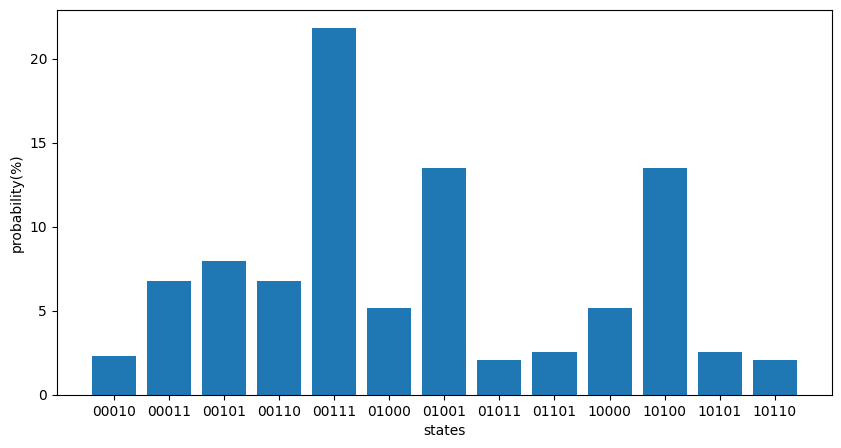

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

threshold = 0.02  # Only print values whose probability above threshold
indices = np.where(probs > threshold)[0]
z_basis_filtered = [format(i, "b").zfill(num_qubits) for i in indices]
probs_filtered = probs[indices]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis_filtered, probs_filtered * 100)
plt.show()
